# Introduction

Fortunately, with libraries such as Scikit-Learn, it’s now easy to build and use almost any machine learning algorithm. But it’s helpful to have an idea of how a machine learning model works under the hood. This lets us diagnose the model when it’s underperforming or explain how it makes decisions, which is crucial if we want to convince others to trust our models.
In this assignment, we’ll look at how to build and use the Decision Tree and the Random Forest in Python. We’ll start by understanding how a single decision tree makes classifications on a simple problem. Then, we’ll work our way to using a random forest on a real-world data science problem.

# Dataset

The dataset we will use in this assignment is the Sonar dataset.

This is a dataset that describes sonar chirp returns bouncing off different surfaces. The 60 predictors are the strength of the returns at different angles. It is a binary classification problem that requires a model to differentiate rocks from metal cylinders. There are 208 observations.

It is a well-understood dataset. All of the variables are continuous and generally in the range of 0 to 1. The output variable is a string “M” for mine and “R” for rock, which will need to be converted to integers 1 and 0.

By predicting the class with the most observations in the dataset (M or mines) the Zero Rule Algorithm can achieve an accuracy of 53%.

You can learn more about this dataset at the UCI Machine Learning repository.
https://archive.ics.uci.edu/ml/datasets/Connectionist+Bench+(Sonar,+Mines+vs.+Rocks)

Download the dataset for free and place it in the "data" folder in your working directory with the filename sonar.all-data.csv.

# Import section

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
import tests

In [3]:
RANDOM_STATE = 2020

# Preprocess data

Read data and convert targets to integers 1 and 0.

In [4]:
PATH = 'data/'
df = pd.read_csv(PATH + 'sonar.all-data.csv', header=None)
df.columns = [f'feat_{col}' if col != 60 else 'target' for col in df.columns]
df['target'] = df['target'].map({'M': 1, 'R': 0})
df.head()

,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,...,feat_51,feat_52,feat_53,feat_54,feat_55,feat_56,feat_57,feat_58,feat_59,target
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,0
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,0
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,0
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,0
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,0


# Split data (train and test)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='target'), df['target'], test_size=0.2,
                                                    random_state=RANDOM_STATE)

# Homework part 1. Implementation of Random Forest Classifier.

## Splitting criteria

**Task 1 - 2 points.** In this section you should implement two criteria for splitting of the feature space. Any of these can be used in the model.

### Gini index

0.5 points for *gini_index* function

In [6]:
def gini_index(x):
    """ Calculate Gini Index for a node
    Args:
        x: Numpy-array of targets in a node
    Returns:
        float: Gini index
    """
    len_x = len(x)
    if len_x == 0 or len_x == 1:
        return 0.0

    return np.abs(np.subtract.outer(x, x)).mean()

    #   https://numpy.org/doc/stable/reference/generated/numpy.ufunc.outer.html
    #   https://numpy.org/doc/stable/reference/generated/numpy.subtract.html
    # r = np.empty((len_x, len_x))
    # for i in range(len_x):
    #     for j in range(len_x):
    #         r[i, j] = x[j] - x[i]
    #
    # gini_index = np.abs(r).mean()

In [7]:
tests.test_gini_index(gini_index)

 All good!


0.5 points for *gini_gain* function

In [8]:
def gini_gain(parent_node, splits):
    """ Calculate Gini Gain for a particular split
    Args:
        parent_node: Numpy-array of targets in a parent node
        splits: List of two numpy-arrays. Each numpy-array is targets in a child node
    Returns:
        float: Gini gain
    """
    parent_gini = gini_index(parent_node)
    weighted__split_entropy = np.sum(
        [(len(splits[i]) / len(parent_node)) * gini_index(splits[i]) for i in range(len(splits))])
    return parent_gini - weighted__split_entropy

In [9]:
tests.test_gini_gain(gini_gain)

 All good!


В нашем случае, тут Gini Impurity
Gini Impurity != Gini coefficient
Gini Impurity используется в деревьях решений как критерий качества разбиения в задачах классификации. А Gini coefficient как метрика качества исследуемого признака.
- [https://habr.com/ru/company/ods/blog/350440/](https://habr.com/ru/company/ods/blog/350440/)
- [https://tproger.ru/translations/python-random-forest-implementation/](https://tproger.ru/translations/python-random-forest-implementation/)

### Entropy

0.5 points for *entropy* function. WARNING! Use only natural logarithm np.log() for calculation.

In [10]:
def entropy(x):
    """ Calculate Entropy for a node
    Args:
        x: Numpy-array of targets in a node
    Returns:
        float: Entropy
    """
    # If you use vectorized operations on a vector of frequencies p
    # where some of the relative frequencies may be 0, and you need to evaluate
    # the expression p * np.log(p), you can use the "where" argument of the np.log() function.
    # This will leave those elements of the array untouched by the function, 
    # thus evaluating x*log(x) as zero, exactly as we want it to be.

    elements, counts = np.unique(x, return_counts=True)
    entropy = np.sum([(-counts[i] / np.sum(counts)) * np.log(counts[i] / np.sum(counts)) for i in range(len(elements))])
    return entropy

In [11]:
tests.test_entropy(entropy)

 All good!


0.5 points for *information_gain* function

In [12]:
def information_gain(parent_node, splits):
    """ Calculate Information Gain for a particular split
    Args:
        parent_node: Numpy-array of targets in a parent node
        splits: List of two numpy-arrays. Each numpy-array is targets in a child node
    Returns:
        float: Information Gain
    """

    # https://python-course.eu/machine-learning/decision-trees-in-python.php
    # https://analyticsindiamag.com/a-complete-guide-to-decision-tree-split-using-information-gain/

    parent_entropy = entropy(parent_node)
    weighted__split_entropy = np.sum(
        [(len(splits[i]) / len(parent_node)) * entropy(splits[i]) for i in range(len(splits))])
    return parent_entropy - weighted__split_entropy

In [13]:
tests.test_information_gain(information_gain)

 All good!


## Split function

**Task 2 - 1 point** Implement *split_dataset* function. <br>
The rows of the dataframe received by a tree node are split into two dataframes depending on their values in a selected column. Rows with values smaller than the chosen

are stored in the resulting left dataframe, and we save rows with values larger than the threshold in the right dataframe. The array with target values should be split in accordance with the feature dataframe.

In [14]:
def split(X, y, value):
    """ Split y-values in order to calculate gain later
    Args:
        X: 1-dimensional numpy-array of data predictor with shape (N,)
        y: 1-dimensional numpy-array of targets with shape (N,)
        value (float): the value by which the X should be splitted
    Returns:
        Two 1-dimensional numpy-arrays with targets related to splits
    """
    left_mask = X < value
    right_mask = X >= value
    return y[left_mask], y[right_mask]


def split_dataset(X, y, column, value):
    """ Split dataset by a particular column and value
    Args:
        X: 2-dimensional numpy-array (N, num_feats). N-number of samples
        y: 1-dimensional numpy-array of targets with shape (N,)  
        column (int): the column by which the X should be splitted
        value (float): the value by which the column should be splitted
    Returns:
        Two 2-dimensional numpy-arrays with data and two 1-dimensional numpy-arrays with targets related to splits
        left_X, right_X, left_y, right_y
    """
    left_mask = X[:, column] < value
    right_mask = X[:, column] >= value
    left_y, right_y = y[left_mask], y[right_mask]
    left_X, right_X = X[left_mask], X[right_mask]
    return left_X, right_X, left_y, right_y

In [15]:
tests.test_split_dataset(split_dataset)

 All good!


## Decision tree

**Task 3 - 4.5 points** In the Tree class below you need to complete the *fit(), predict_row()* and *predict()* functions.<br>
Each tree is basically a tree node that may have a left and a right child that are also trees. If a tree doesn't have any child nodes, we call it a leaf.<br>
Since features for splitting a dataframe are chosen randomly, we need a mechanism to control this randomness to aquire reproducibility for testing purposes. In our case we use the [Random Generator](https://numpy.org/doc/stable/reference/random/generator.html)<br>
By creation of a tree only the **criterion** and the **rng** fields are not filled with Nones, so each tree knows what criterion for dataframe splitting it should use. Each fitted tree knows as well by which column and value the split should be performed. If a tree is a leaf it doesn't have information about the split, but stores the predicted value.

In [16]:
class Tree(object):
    """A decision tree classifier.

    Args:
        criterion : {"gini", "entropy"}, default="gini"
            The function to measure the quality of a split. Supported criteria are
            "gini" for the Gini impurity and "entropy" for the information gain.
        random_gen: numpy Random Generator object, default=None
            Generator should be passed over for reproducible results. If None, 
            a new np.random.default_rng() will be created.
    """

    def __init__(self, criterion='gini', random_gen=None):
        if criterion not in ["gini", "entropy"]:
            raise ValueError(f'Unknown criteria for splits {criterion}')
        self.criterion = criterion
        self.threshold = None  # value of the next split
        self.column_index = None  # column to use for the next split
        self.outcome_probs = None  # the predicted value if the tree is a leaf
        self.left_child = None
        self.right_child = None
        self.rng = random_gen if random_gen is not None else np.random.default_rng()

    @property
    def is_terminal(self):
        """Define is it terminal node."""
        return not bool(self.left_child and self.right_child)

    def _compute_gain(self, y, splits):
        """Compute split gain according to chosen criteria."""
        func = gini_gain if self.criterion == 'gini' else information_gain
        return func(y, splits)

    def _find_splits(self, X):
        """Find all possible split values."""
        split_values = set()

        # Get unique values in a sorted order
        x_unique = list(np.unique(X))
        for i in range(1, len(x_unique)):
            # Find a point between two values
            average = (x_unique[i - 1] + x_unique[i]) / 2.0
            split_values.add(average)

        return list(split_values)

    def _find_best_split(self, X, y, n_features):
        """Find best feature and value for a split. Greedy algorithm."""
        # Sample random subset of features
        subset = self.rng.choice(list(range(0, X.shape[1])), n_features, replace=False)

        max_gain, max_col, max_val = None, None, None

        for column in subset:
            split_values = self._find_splits(X[:, column])
            for value in split_values:
                splits = split(X[:, column], y, value)
                gain = self._compute_gain(y, splits)

                if (max_gain is None) or (gain > max_gain):
                    max_col, max_val, max_gain = column, value, gain
        return max_col, max_val, max_gain

    def _compute_outcome(self, y):
        """Save outcome probabilities for the leaf."""
        self.outcome_probs = np.around(np.sum(y) / y.shape[0])

    def fit(self, X, y, feature_frac=1.0, max_depth=None):
        """Fit model.

        Args:
            X (numpy-array):      The training input samples. 2-dimensional numpy array.
            y (numpy-array):      The target values. 1-dimensional numpy array.
            feature_frac (float): The fraction of features to use when fit is performed. Must be 
                                  between 0.0 and 1.0 (default: 1.0, i.e. all features).
            max_depth (int):      The maximum depth of the tree. If None, then nodes are expanded
                                  until all leaves are pure.
        """
        # 3 points

        # Make this tree a leaf and return if max_depth doesn't allow it to grow further
        if max_depth is not None and None:
            pass

        if not 0.0 <= feature_frac <= 1.0:
            raise ValueError('feature_frac must lie between 0.0 and 1.0')
        # Compute the number of features to use. Should be integer number
        n_features = int(None)

        # Find the next split    
        column, value, gain = None

        # Make this tree a leaf and return if the split doesn't bring any gain
        if gain is None or None:
            pass

        # Save the necessary information about the next split
        pass

        # Reduce the max_depth parameter for the next tree
        if max_depth is not None:
            pass

        # Split dataset
        left_X, right_X, left_target, right_target = None

        # Grow left and right child. Pass over the parent's random generator
        # for reproducible results 
        self.left_child = None
        pass

        self.right_child = None
        pass

    def predict_row(self, row):
        """Predict single row."""
        # 0.5 points

        if not self.is_terminal:
            # Use the stored information about the split to define 
            # if the right or the left child to use
            if row[None] < None:
                pass
            else:
                pass
        return None

    def predict(self, X):
        """Make predictions.

        Args:
            X (numpy-array): The test input samples. 2-dimensional numpy array.
        Returns:
            1-dimensional numpy-array with predictions     
        """
        # 1 point

        # Create a numpy array of zeros of necessary length to save predictions
        result = np.zeros(np.shape(X)[0])
        # Go through all rows of the dataset
        for i in range(len(X)):
            # Save the prediction for the current row
            if self.predict_row(X[i]) > 0.5:
                np.append(result, 1)
            else:
                np.append(result, 0)
        return result

Я не готов, что-то запрограммировать осознано, пока не понимаю как это применить в будущем на практике. Поэтому ниже пока исследования подробностей работы DecisionTreeClassifier из библиотеки sklearn. Если вы это читаете, то просто не хватило времени разобраться во всех тонкостях работы библиотечного DecisionTreeClassifier и переписать весь код на свою реализацию. Метод predict сделан сразу, на будущее, чтобы не 0 :)

In [17]:
# tests.test_tree(Tree)

**Task 4 - 1 point** Fit two models with "max_depth=3" and "max_depth=None" hyperparameters. **Explain** the results.

In [18]:
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline

In [19]:
X, y = df.drop(columns='target'), df['target']

In [20]:
kfold = KFold(n_splits=10, random_state=RANDOM_STATE, shuffle=True)
pipe = Pipeline([('decisionTree', DecisionTreeClassifier(max_depth=3, random_state=RANDOM_STATE))])

y_pred_max_d_3 = cross_val_predict(pipe, X, y, cv=kfold)
scores = cross_val_score(pipe, X, y, cv=kfold)

In [21]:
print("%0.2f accuracy со standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.69 accuracy со standard deviation of 0.08


In [22]:
# Your code here
pipe = Pipeline([('decisionTree', DecisionTreeClassifier(max_depth=None, random_state=RANDOM_STATE))])

y_pred_max_d_none = cross_val_predict(pipe, X, y, cv=kfold)
scores = cross_val_score(pipe, X, y, cv=kfold)

In [23]:
print("%0.2f accuracy со standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.71 accuracy со standard deviation of 0.07


С увеличением максимальной глубины, accuracy увеличивается, а стандартное отклонение уменьшается. Посмотрим детально на accuracy

In [24]:
# https://developers.google.com/machine-learning/crash-course/classification/accuracy
# Минерал - 1 , Камень - 0
def describe_conf_matrix_results(confusion_matrix_results):
    tn, fp, fn, tp = confusion_matrix_results.ravel()
    print('Позитив - минерал, негатив - камень')
    display(pd.DataFrame((
        ('Минерал', 'Минерал', 'TP', tp),
        ('Камень', 'Минерал', 'FN', fn),
        ('Камень', 'Камень', 'TN', tn),
        ('Минерал', 'Камень', 'FP', fp),
    ), columns=['УТВЕРЖДАЕМ', 'РЕАЛЬНОСТЬ', 'МЕТКА', 'КОЛИЧЕСТВО РАЗ']))
    print('Значение Accuracy составляет', (tp + tn) / (tp + tn + fp + fn))

In [25]:
conf_mat_3 = confusion_matrix(y, y_pred_max_d_3)
conf_mat_none = confusion_matrix(y, y_pred_max_d_none)
print('Максимальная глубина дерева 3')
describe_conf_matrix_results(conf_mat_3)

Максимальная глубина дерева 3
Позитив - минерал, негатив - камень


,УТВЕРЖДАЕМ,РЕАЛЬНОСТЬ,МЕТКА,КОЛИЧЕСТВО РАЗ
0,Минерал,Минерал,TP,75
1,Камень,Минерал,FN,36
2,Камень,Камень,TN,68
3,Минерал,Камень,FP,29


Значение Accuracy составляет 0.6875


In [26]:
print('Нет ограничений по глубине дерева')
describe_conf_matrix_results(conf_mat_none)

Нет ограничений по глубине дерева
Позитив - минерал, негатив - камень


,УТВЕРЖДАЕМ,РЕАЛЬНОСТЬ,МЕТКА,КОЛИЧЕСТВО РАЗ
0,Минерал,Минерал,TP,81
1,Камень,Минерал,FN,30
2,Камень,Камень,TN,66
3,Минерал,Камень,FP,31


Значение Accuracy составляет 0.7067307692307693


Модель без ограничений по глубине дерева гораздо лучше определяет минералы, хотя при этом наблюдается ухудшение прогноза по камням - 66 камней было определено, вместо 68, а ошиблись 31 раз, вместо 29.

In [27]:
def plot_metrics_on_depths(criterion='gini'):
    max_depths, train_scores, test_scores = [], [], []
    for max_depth in range(1, 8):
        max_depths.append(max_depth)
        model = DecisionTreeClassifier(criterion=criterion, max_depth=max_depth, random_state=RANDOM_STATE)
        model.fit(X_train.values, y_train.values)
        train_scores.append(accuracy_score(y_train, model.predict(X_train.values)))
        y_pred = model.predict(X_test.values)
        test_scores.append(accuracy_score(y_test, y_pred))
    res_metrics = pd.DataFrame(data={'train': train_scores, 'test': test_scores}, index=max_depths)
    sns.set(rc={'figure.figsize': (16, 6)})
    plt.plot(res_metrics['train'], label='train score')
    plt.plot(res_metrics['test'], label='test score')
    plt.title("Accuracy as a function of max_depth")
    plt.xlabel('max_depth')
    plt.ylabel('accuracy')
    plt.legend()
    plt.show()

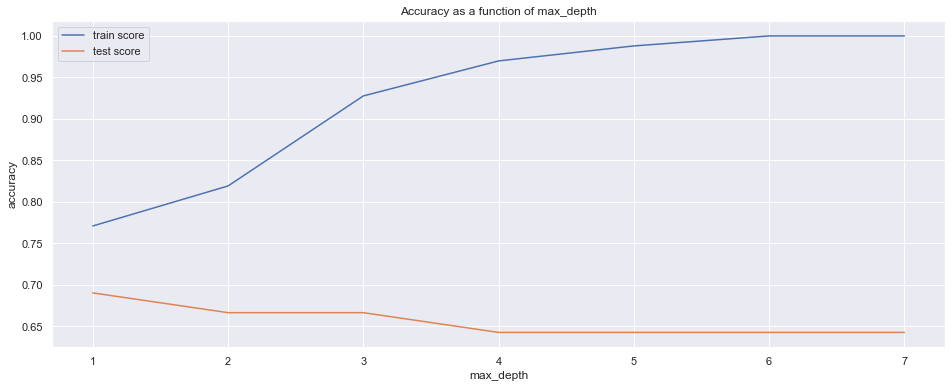

In [28]:
plot_metrics_on_depths('gini')

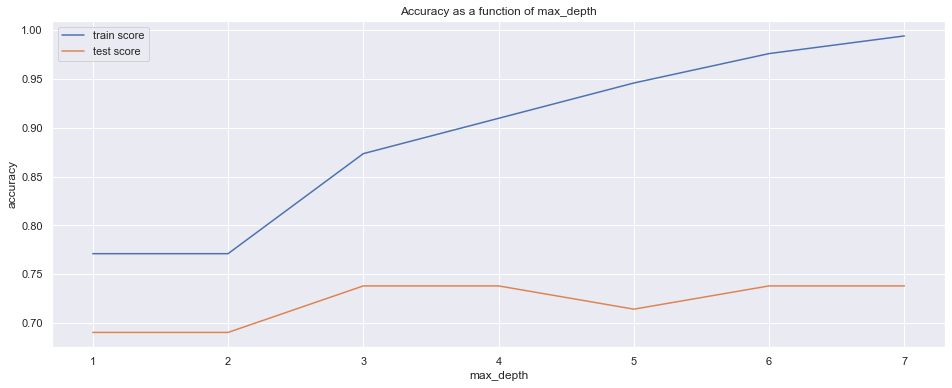

In [29]:
plot_metrics_on_depths('entropy')

На графиках выше взято обычное разделение на 80% 20% тренировочных и тестовых данных, без кросс валидации. Мы можем наблюдать, что с увеличением максимальной глубины дерева от 1 до 8 для параметра "энтропия" наблюдается рост Accuracy, а для параметра "gini" наблюдается снижение Accuracy на тестовых данных. Какой можно сделать вывод? Да никакой - утверждать, что gini хуже entory я бы не стал, по этим графикам до конца непонятно где мы лучше, а где хуже угадываем прогноз или ошибаемся. Нужно дополнительно исследовать технические подробности Accuracy через confusion_matrix для всех max_depth от 1 до 8 и разных параметров criterion - gini и entropy. Слишком хлопотно для 1 балла. :( Выше было видно, что модель лучше ведёт себя когда нет ограничений максимальной глубины дерева.

## Random forest

**Task 5 - 1.5 Points** In the RandomForestClassifier class below you need to complete the *fit* and *predict()* functions

In [30]:
class MyRandomForestClassifier(object):
    """
    A random forest classifier.
    A random forest is a meta estimator that fits a number of decision tree
    classifiers on various sub-samples of the dataset and uses averaging to
    improve the predictive accuracy and control overfitting.
    
    Args:
        n_estimators : int, default=10
            The number of trees in the forest.

        max_depth : int, default=None
            The maximum depth of the tree. If None, then nodes are expanded until
            all leaves are pure.        

        feature_frac : float, default=None
            The fraction of features to use when looking for the best split. Must be 
            between 0.0 and 1.0. If None, then `feature_frac = 1 / sqrt(n_features)`.

        criterion : {"gini", "entropy"}, default="gini"
            The function to measure the quality of a split. Supported criteria are
            "gini" for the Gini impurity and "entropy" for the information gain.
            
        random_gen: numpy Random Generator object, default=None
            Generator should be passed over for reproducible results. If None, 
            a new np.random.default_rng() will be created.
    """

    def __init__(self, n_estimators=10, max_depth=None, feature_frac=None,
                 criterion="entropy", bootstrap=True, random_gen=None):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.bootstrap = bootstrap
        self.feature_frac = feature_frac

        if criterion not in ["gini", "entropy"]:
            raise ValueError(f'Unknown criteria for splits {criterion}')
        self.criterion = criterion

        self.rng = random_gen if random_gen is not None else np.random.default_rng()
        self.trees = [Tree(criterion=self.criterion, random_gen=self.rng)
                      for _ in range(n_estimators)]

    def _init_data(self, X, y):
        """Ensure data are in the expected format.
        Ensures X and y are stored as numpy ndarrays by converting from an
        array-like object if necessary. 
        Parameters
        Args:
            X : array-like
                Feature dataset.
            y : array-like, default=None
                Target values. By default is required, but if y_required = false
                then may be omitted.
        """
        self.size = len(X)

        if not isinstance(X, np.ndarray):
            self.X = np.array(X)
        else:
            self.X = X

        if not isinstance(y, np.ndarray):
            self.y = np.array(y)
        else:
            self.y = y

    def bootstrap_data(self, size):
        return self.rng.integers(size, size=size)

    def fit(self, X, y):
        """Fit model.

        Args:
            X (numpy-array): The training input samples. 2-dimensional numpy array.
            y (numpy-array): The target values. 1-dimensional numpy array.
        """
        # 0.5 points

        if self.feature_frac is None:
            self.feature_frac = 1 / np.sqrt(X.shape[1])
        elif not 0.0 <= self.feature_frac <= 1.0:
            raise ValueError('feature_frac must lie between 0.0 and 1.0')

        self._init_data(X, y)

        # Iterate over all trees in the forest
        for tree in None:
            if self.bootstrap:
                idxs = self.bootstrap_data(self.size)
                X = self.X[idxs]
                y = self.y[idxs]
            else:
                X = self.X
                y = self.y

            # Fit the tree    
            pass

    def predict(self, X):
        """Make predictions.

        Args:
            X (numpy-array): The test data input samples. 2-dimensional numpy array.
        """
        # 1 point

        if not isinstance(X, np.ndarray):
            X = np.array(X)

        if self.X is not None:
            # Create a numpy array of zeros of necessary length
            predictions = None
            # Go through all rows of the dataset
            for i in None:
                # Initialize a counter for voting
                row_pred = None
                # Sum up predictions from all the voters
                for tree in None:
                    pass
                # Compute the mean of the votes    
                row_pred = None
                # Save the rounded value as the prediction for the current row
                pass
            return predictions
        else:
            raise ValueError("You should fit a model before `predict`")

In [31]:
# tests.test_random_forest(RandomForestClassifier)

RF (random forest) — это множество деревьев в лесу.
RandomForestClassifier имеет параметр n_estimators - количество деревьев в лесу.
Получая результаты по каждому дереву, в задачах регрессии их результаты усредняются, в задаче классификации принимается решение голосованием по большинству.

Все деревья строятся независимо по следующей схеме:

- Выбирается подвыборка обучающей выборки определённого размера
- по выборке строится дерево (для каждого дерева — своя подвыборка).
- Для построения каждого расщепления в дереве просматриваем max_features случайных признаков (для каждого нового расщепления — свои случайные признаки).
- Выбираем наилучшие признак и расщепление по нему (по заранее заданному критерию).
- Дерево строится, как правило, до исчерпания выборки (пока в листьях не останутся представители только одного класса), но в современных реализациях есть параметры, которые ограничивают высоту дерева, число объектов в листьях и число объектов в подвыборке, при котором проводится расщепление.

[https://dyakonov.org/2016/11/14/случайный-лес-random-forest/](https://dyakonov.org/2016/11/14/случайный-лес-random-forest/)

Вроде всё и понятно, но реализация своего кода по MyRandomForestClassifier отложена пока не пришло полное осознание :)

**Task 6 - 1 Point** Fit two models with "n_estimators=10" and "n_estimators=100" hyperparameters. **Explain** the results.

In [32]:
from sklearn.ensemble import RandomForestClassifier

In [33]:
pipe = Pipeline([('RandomForest', RandomForestClassifier(n_estimators=10, random_state=RANDOM_STATE))])

y_pred_rf_10 = cross_val_predict(pipe, X, y, cv=kfold)
scores_10_trees = cross_val_score(pipe, X, y, cv=kfold)

In [34]:
print("%0.2f accuracy со standard deviation of %0.2f" % (scores_10_trees.mean(), scores_10_trees.std()))

0.77 accuracy со standard deviation of 0.06


In [35]:
pipe = Pipeline([('RandomForest', RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE))])

y_pred_rf_100 = cross_val_predict(pipe, X, y, cv=kfold)
scores_100_trees = cross_val_score(pipe, X, y, cv=kfold)

In [36]:
print("%0.2f accuracy со standard deviation of %0.2f" % (scores_100_trees.mean(), scores_100_trees.std()))

0.83 accuracy со standard deviation of 0.06


В целом метрика accuracy для RandomForestClassifier имеет большие значения, чем DecisionTreeClassifier, а стандартное отклонение меньше 0.06 вместо 0.08(0.07).
Чем больше деревьев n_estimators, тем больше значение accuracy.


In [37]:
conf_mat_10 = confusion_matrix(y, y_pred_rf_10)
conf_mat_100 = confusion_matrix(y, y_pred_rf_100)

In [38]:
print('10 Деревьев')
describe_conf_matrix_results(conf_mat_10)

10 Деревьев
Позитив - минерал, негатив - камень


,УТВЕРЖДАЕМ,РЕАЛЬНОСТЬ,МЕТКА,КОЛИЧЕСТВО РАЗ
0,Минерал,Минерал,TP,85
1,Камень,Минерал,FN,26
2,Камень,Камень,TN,76
3,Минерал,Камень,FP,21


Значение Accuracy составляет 0.7740384615384616


In [39]:
print('100 Деревьев')
describe_conf_matrix_results(conf_mat_100)

100 Деревьев
Позитив - минерал, негатив - камень


,УТВЕРЖДАЕМ,РЕАЛЬНОСТЬ,МЕТКА,КОЛИЧЕСТВО РАЗ
0,Минерал,Минерал,TP,99
1,Камень,Минерал,FN,12
2,Камень,Камень,TN,74
3,Минерал,Камень,FP,23


Значение Accuracy составляет 0.8317307692307693


RandomForestClassifier по умолчанию для параметра [n_estimators имеет значение 100](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier). Уменьшая это значение до 10 мы сокращаем количество сгенерированных деревьев. При этом снижается эффективность прогнозирования, очень сильно ухудшаются показатели TP и FN.

Now it's your turn to explore the various parameters of RandomForestClassifier and their influence on model quality.

# Homework part 2. Random Forest in action

_Note_: Consider **accuracy** as main metric of model performance on this dataset.

_Note_: For tasks 1 to 5 please use your custom RandomForestClassifier if it is completed.

**Task 1 (0.5 points)** Split the dataset into train, test and validation parts (0.6 / 0.2 / 0.2). First two will be used for model hyperparameter tuning whereas the best model quality should be evaluated on validation part.

In [40]:
# Your code here
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='target'), df['target'], test_size=0.4,
                                                    random_state=RANDOM_STATE)
X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.5,
                                                    random_state=RANDOM_STATE)

### Grid Search and Random Search

If you have enough computational power for model training in a reasonable amount of time more sophisticated approach of hyperparameter tuning would be either Grid Search or Random Search.<br>

In a nutshell Grid Search allows you to pass through all different combinations of given model parameters and their values and choose the best combination. Whereas Random Search would randomly choose values for given model parameters and evaluate them on test data untill it reaches the specified number of iterations.<br>

More information here [Gentle introduction to Grid and Random search](https://medium.com/@senapati.dipak97/grid-search-vs-random-search-d34c92946318) and here [Detailed Explanation with code examples](https://machinelearningmastery.com/hyperparameter-optimization-with-random-search-and-grid-search/).

![grid_random_search.png](https://raw.githubusercontent.com/rolling-scopes-school/ml-intro/2022/7_trees_and_ensembles/grid_random_search.png)
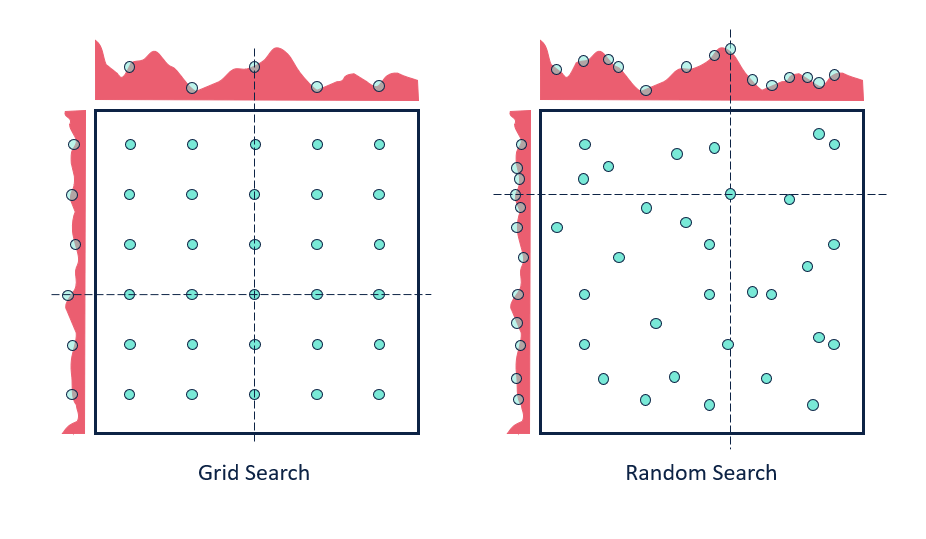

**Task 3 (1 point)**. Compare your previous results with [GridSearch](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) hyperparameter tuning. You may tune best hyperparameters for forest with several trees and then increase it while measure the quality on validation dataset.

In [41]:
from sklearn.model_selection import GridSearchCV

model = RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=100)
params = dict({"criterion": ["gini", "entropy"], "max_depth": [None, 10, 5], "max_samples": [None, 0.3, 0.5, 0.7]})
grid = GridSearchCV(estimator=model, param_grid=params, cv=kfold)
grid.fit(X_train, y_train)
y_pred_grid_search = grid.predict(X_test)

In [42]:
accuracy_score(y_true=y_test, y_pred=y_pred_grid_search)

0.7142857142857143

GridSearchCV предоставляет возможность пройтись по всем параметрам param_grid и применить их значения в конструкторе estimator. В результате такого подхода будет модель выбрана модель с лучшим результатом метрики, указанной в GridSearchCV::scoring.

In [43]:
pipe.fit(X_train, y_train)
accuracy_score(y_true=y_test, y_pred=pipe.predict(X_test))

0.6428571428571429

Значения метрики accuracy по GridSearch равно 0.71, что больше значения метрики 0.64, если взять просто RandomForestClassifier(n_estimators=100). С увеличением списка параметров для GridSearch увеличивается время выполнения алгоритма. Результатов пришлось ждать "очень долго" - это минус GridSearch. Посмотреть какая лучшая модель можно с помощью best_estimator_

In [44]:
grid.best_estimator_

RandomForestClassifier(criterion='entropy', max_depth=5, max_samples=0.7,
                       random_state=2020)

 Сравним ранее полученные результаты с результатами лучшей моделью из GridSearch

In [45]:
print("%0.2f accuracy со standard deviation of %0.2f" % (scores_100_trees.mean(), scores_100_trees.std()))

0.83 accuracy со standard deviation of 0.06


In [46]:
grid.fit(X, y)  # scores_100_trees рассчитывалось на X, y
scores_best_gridsearch = cross_val_score(grid.best_estimator_, X, y, cv=kfold)
print("%0.2f accuracy со standard deviation of %0.2f" % (scores_best_gridsearch.mean(), scores_best_gridsearch.std()))

0.84 accuracy со standard deviation of 0.07


In [66]:
grid.best_estimator_

RandomForestClassifier(criterion='entropy', random_state=2020)

GridSearchCV позволил найти лучшие параметры, улучшив ранее посчитанный результат accuracy.

**Task 4 (1 point)**. And finally tune forest hyperparameters with [RandomSearch](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html). Compare results to previous attempts.

In [68]:
from sklearn.model_selection import RandomizedSearchCV

In [69]:
grid.param_grid

{'criterion': ['gini', 'entropy'],
 'max_depth': [None, 10, 5],
 'max_samples': [None, 0.3, 0.5, 0.7]}

In [70]:
params_random_search = dict(
    {"criterion": ["gini", "entropy"], "max_depth": range(5, 50, 5), "max_samples": np.linspace(0.1, 0.9, 7)})

In [71]:
random_search = RandomizedSearchCV(estimator=model, param_distributions=params_random_search, random_state=RANDOM_STATE, cv=kfold)
random_search.fit(X, y)

RandomizedSearchCV(cv=KFold(n_splits=10, random_state=2020, shuffle=True),
                   estimator=RandomForestClassifier(random_state=2020),
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': range(5, 50, 5),
                                        'max_samples': array([0.1       , 0.23333333, 0.36666667, 0.5       , 0.63333333,
       0.76666667, 0.9       ])},
                   random_state=2020)

In [72]:
random_search.best_score_

0.76981

In [73]:
random_search.best_estimator_

RandomForestClassifier(max_depth=5, max_samples=0.6333333333333333,
                       random_state=2020)

Метрика по RandomizedSearchCV гораздо хуже, которую удалось найти с помощью GridSearch. Это связано с тем, что всё же max_depth и max_samples были указаны бездумно - диапазоном ограниченных значений. Кроме всего прочего тут имеется случайность подбора параметров.

**Task 5 (0.5 points)**. Tell us about your experience in hyperparameter tuning with the approaches above. What do you think would be the best option for this task and why?

Применение GridSearch и RandomizedSearch оправдано тогда, когда это позволяет быстро получать результаты, когда тренировочных данных небольшое количество. Не эффективно тратить десятки минут в ожидании результатов. Также необходимо ясное представление, как работает тот или иной параметр модели, так как бездумное указание вариантов параметра в поисках лучшего скорее всего приведёт к заблуждению в сделанных впоследствии выводов.

### Desicion tree explained

Remember the [Titanic](https://www.kaggle.com/c/titanic) competition from last week? Wouldn't be a good idea to visualize one of possible desicion-making processes of _survived_ / _dead_ labeling?

**Task 6 (1 point)**. Load titanic dataset, split it into train/test parts, apply simple hyperparameter tuning of [DesicionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) (use one of the approaches above) in order to have **test accuracy more than 0.65**. <br>

Draw the best tree decision making process. You may use [sklearn.tree.prot_tree](https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html).<br>

In [48]:
import os
from sklearn.tree import DecisionTreeClassifier

PATH = "./data/"
data = pd.read_csv(os.path.join(PATH, 'titanic', 'train.csv')).set_index('PassengerId')


def prep_data(data: pd.DataFrame, return_y=True):
    work_data = data.copy()

    work_data.Sex = np.where(work_data.Sex == 'male', 0, 1)

    work_data.Embarked = np.where((work_data.Embarked.isnull()) & (work_data.Sex == 0), 0.35, work_data.Embarked)
    work_data.Embarked = np.where((work_data.Embarked.isnull()) & (work_data.Sex == 1), 0.525, work_data.Embarked)
    work_data.Embarked = work_data.Embarked.replace(['S', 'C', 'Q', ], [0.3, 0.60, 0.75])

    work_data.Age = work_data.Age.fillna(10.0)

    work_data.Fare = work_data.Fare.fillna(24.5)

    work_data['Family'] = work_data.SibSp + work_data.Parch
    work_data['Alone'] = np.where(work_data['Family'] == 0, 1, 0)

    X = work_data.loc[:, ['Sex', 'Pclass', 'Embarked', 'Age', 'Fare', 'Family', 'Alone']]

    if return_y:
        Y = work_data.Survived
        return X, Y

    return X

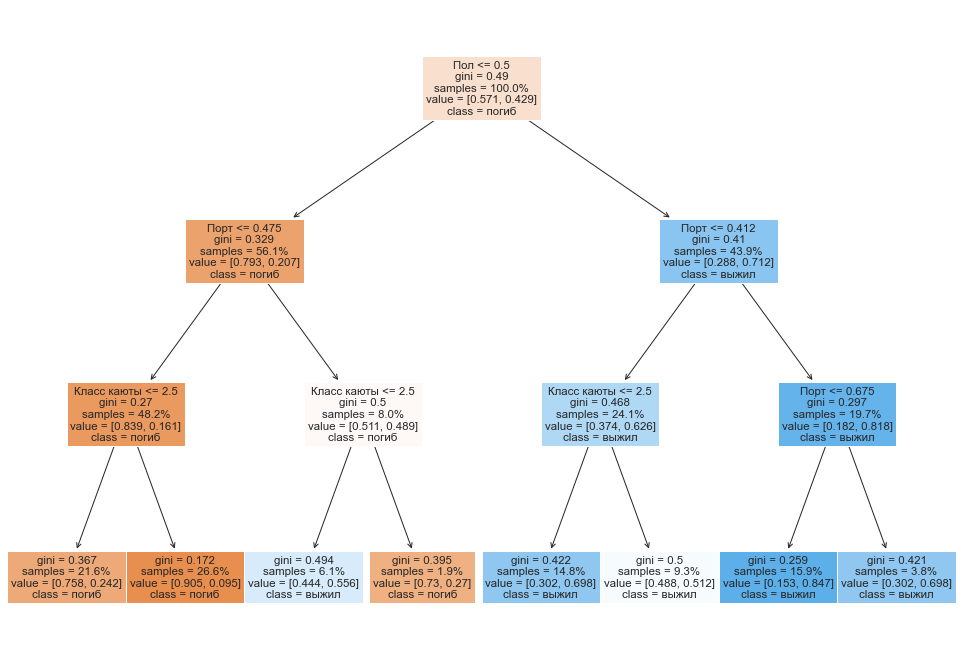

In [49]:
from sklearn import tree

X, y = prep_data(data)
decisionTree = DecisionTreeClassifier(max_depth=3)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
decisionTree.fit(X_train, y_train)

plt.figure(figsize=(17, 12))
tree.plot_tree(decisionTree, feature_names=['Пол', 'Класс каюты', 'Порт', 'Возраст', 'Тариф', 'Семья', 'Alone'],
               class_names=['погиб', 'выжил', ], filled=True, proportion=True)
plt.show()

In [50]:
accuracy_score(y_true=y_test, y_pred=decisionTree.predict(X_test))

0.7621

Результат accuracy больше 0.65

In [51]:
def describe_titanic_conf_matrix_results(confusion_matrix_results):
    tn, fp, fn, tp = confusion_matrix_results.ravel()
    print('Позитив - выжил, негатив - погиб')
    display(pd.DataFrame((
        ('выжил', 'выжил', 'TP', tp),
        ('погиб', 'выжил', 'FN', fn),
        ('погиб', 'погиб', 'TN', tn),
        ('выжил', 'погиб', 'FP', fp),
    ), columns=['УТВЕРЖДАЕМ', 'РЕАЛЬНОСТЬ', 'МЕТКА', 'КОЛИЧЕСТВО РАЗ']))
    print('Значение Accuracy составляет', (tp + tn) / (tp + tn + fp + fn))

In [52]:
describe_titanic_conf_matrix_results(confusion_matrix(y_true=y_test, y_pred=decisionTree.predict(X_test)))

Позитив - выжил, негатив - погиб


,УТВЕРЖДАЕМ,РЕАЛЬНОСТЬ,МЕТКА,КОЛИЧЕСТВО РАЗ
0,выжил,выжил,TP,6877
1,погиб,выжил,FN,1592
2,погиб,погиб,TN,8365
3,выжил,погиб,FP,3166


Значение Accuracy составляет 0.7621


Is it easy to interpret its results? Are you able to explain to a random person why would they survive / die on the titanic?

В главном узле дерева находится X[0], что является полом, на втором уровне дерева находится X[2], что является портом. Алгоритм со стратегией gini определил эти два признака главными на выживание (в данной выборке признаков). Случайному человеку можно визуально показать, как происходит выбор вариантов, двигаясь с 0 уровня глубины до максимального, при этом проговаривая вопрос "Признах x больше числового значения", если да, то двигаемся влево, нет - вправо.

Так как данные в прошлых работах были по EDA подготовлены и подобраны сразу удачные характеристики(колонки), то и значение метрики Accuracy сразу оказалось больше 0.65. При этом модель DecisionTreeClassifier используется max_depth=3, так как это легко наглядно показать. Можно применить GridSearch для поиска лучших параметров для DecisionTreeClassifier, но визуальное отображение дерева в этом случае скорее всего не получится, так как максимальная глубина будет убрана или увеличена. Проверяем ...

In [80]:
modelTitanic = DecisionTreeClassifier()
params = dict({"criterion": ["gini", "entropy"], "max_depth": [None, 5, 3]})
grid = GridSearchCV(estimator=modelTitanic, param_grid=params, cv=kfold)

In [81]:
grid.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=2020, shuffle=True),
             estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 5, 3]})

In [82]:
grid.best_estimator_

DecisionTreeClassifier(criterion='entropy', max_depth=5)

In [86]:
accuracy_score(y_true=y_test, y_pred=grid.best_estimator_.predict(X_test))

0.7683

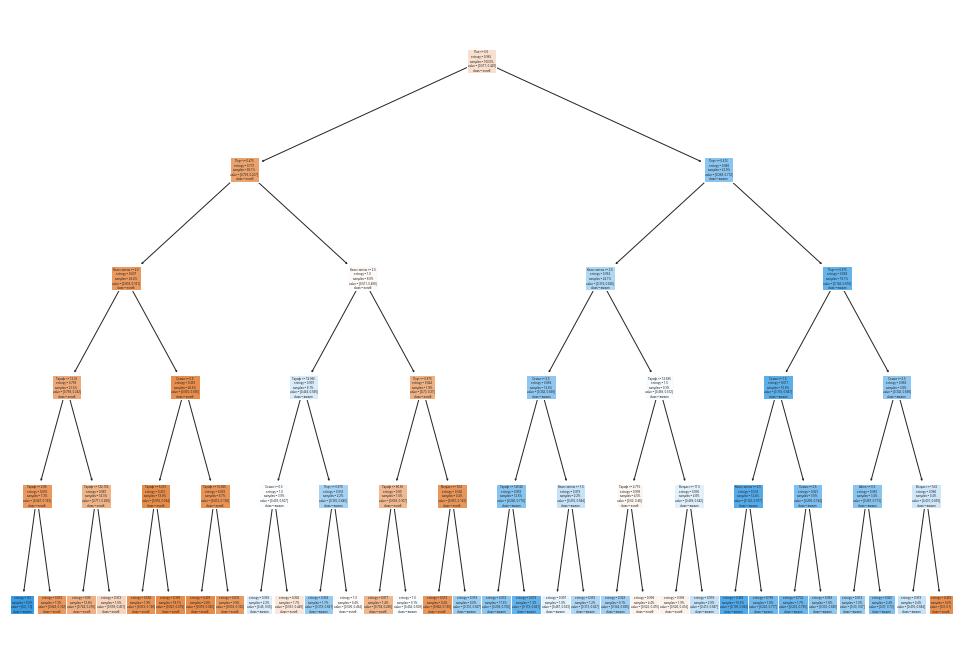

In [87]:
plt.figure(figsize=(17, 12))
tree.plot_tree(grid.best_estimator_, feature_names=['Пол', 'Класс каюты', 'Порт', 'Возраст', 'Тариф', 'Семья', 'Alone'],
               class_names=['погиб', 'выжил', ], filled=True, proportion=True)
plt.show()

Распечатать на ватмане - может и сможем случайному человеку что-то показать и объяснить. Сейчас график дерева, в таком масштабе, никакой смысловой нагрузки не предоставляет. Единственное, определены лучшие параметры `DecisionTreeClassifier(criterion='entropy', max_depth=5)`